In [32]:
import os
import warnings
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense
from keras.backend import clear_session
from keras.metrics import RootMeanSquaredError
import tensorflow as tf

warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

In [33]:
data_dir = Path('../data')

df = pd.read_csv(
    data_dir / 'msft_pretreated_with_dates.csv',
    index_col='Date'
).drop('Unnamed: 0', axis=1)

cols = df.columns
index = df.index

#### Prepare the Data for LSTM


In [34]:
def create_dataset(dataset,window_size):
    X,y = [],[]
    for i in range(len(dataset) - window_size):
        X.append(dataset[i: i + window_size,:-1])
        y.append(dataset[i + window_size,0])

    return np.array(X),np.array(y)

In [35]:
dataset = df.values
dataset = dataset.astype('float32')
window_size = 60

#normalize
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# train test split
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(f'Train shape {train.shape}, test shape {test.shape}')

X_train,y_train = create_dataset(train,window_size=window_size)
X_test,y_test = create_dataset(test,window_size=window_size)

print(f'X_train shape {X_train.shape} , y_train shape {y_train.shape}')
print(f'X_train shape {X_test.shape} , y_train shape {y_test.shape}')

Train shape (3967, 8), test shape (1954, 8)
X_train shape (3907, 60, 7) , y_train shape (3907,)
X_train shape (1894, 60, 7) , y_train shape (1894,)


In [36]:
df_test = df.copy()
df_test = df_test.reset_index()

df_test = df_test.iloc[train_size:len(dataset),:]
df_test = df_test.iloc[60:]

dates = df_test['Date'].tolist()

print(dates)

['2016-01-06', '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28', '2016-01-29', '2016-02-01', '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-16', '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25', '2016-02-26', '2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08', '2016-03-09', '2016-03-10', '2016-03-11', '2016-03-14', '2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23', '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30', '2016-03-31', '2016-04-01', '2016-04-04', '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08', '2016-04-11', '2016-04-12', '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-18', '2016

In [ ]:
clear_session()

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(50,return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(
    optimizer='Adam',
    loss='mean_squared_error',
    metrics=[RootMeanSquaredError()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 33,101
Trainable params: 33,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    verbose=2,
                    epochs=100)

model.save('lstm_pretreated_features.h5')

Epoch 1/100
3907/3907 - 39s - loss: 4.7568e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344 - 39s/epoch - 10ms/step
Epoch 2/100
3907/3907 - 32s - loss: 1.0435e-04 - root_mean_squared_error: 0.0102 - val_loss: 9.0180e-05 - val_root_mean_squared_error: 0.0095 - 32s/epoch - 8ms/step
Epoch 3/100
3907/3907 - 36s - loss: 6.9269e-05 - root_mean_squared_error: 0.0083 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342 - 36s/epoch - 9ms/step
Epoch 4/100
3907/3907 - 36s - loss: 5.7614e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.6563e-05 - val_root_mean_squared_error: 0.0060 - 36s/epoch - 9ms/step
Epoch 5/100
3907/3907 - 36s - loss: 5.0579e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.2236e-05 - val_root_mean_squared_error: 0.0057 - 36s/epoch - 9ms/step
Epoch 6/100
3907/3907 - 37s - loss: 3.9374e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.7028e-05 - val_root_mean_squared_error: 0.0041 - 37s/epoch - 9ms/step
Epoch 7/100
3907/

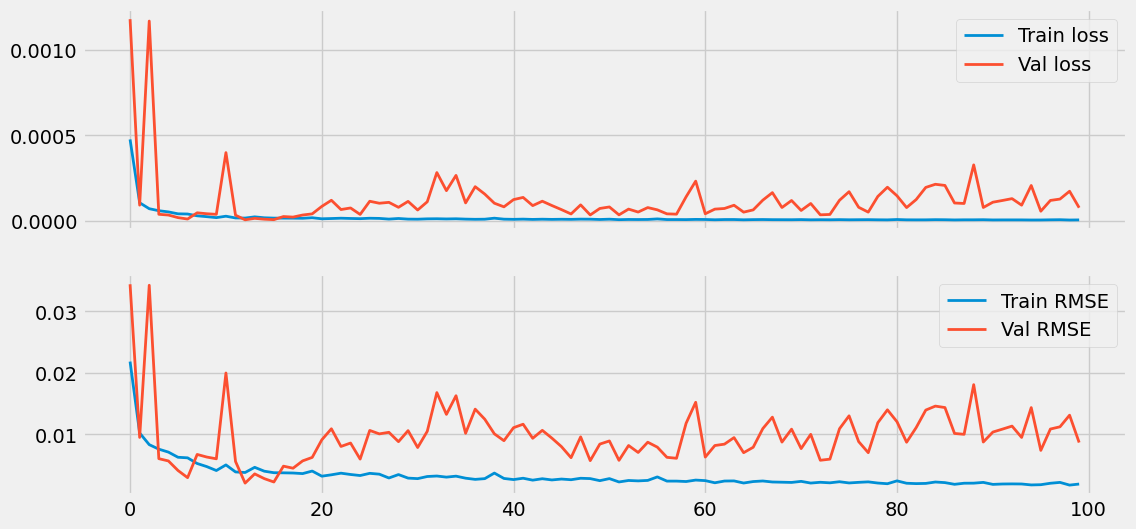

In [ ]:
history_df = pd.DataFrame(history.history)

plt.rc(
    'lines',
    linewidth=2
)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6),sharex=True)

history_df['loss'].plot(ax=ax1, label='Train loss')
history_df['val_loss'].plot(ax=ax1, label='Val loss')
ax1.legend()

history_df['root_mean_squared_error'].plot(ax=ax2, label='Train RMSE')
history_df['val_root_mean_squared_error'].plot(ax=ax2, label='Val RMSE')
ax2.legend()

plt.show()

In [37]:
model = load_model('../models/lstm_pretreated_features.h5')

fitted = model.predict(X_train)
preds = model.predict(X_test)

#inverse transform train,test
inv_train = pd.DataFrame(scaler.inverse_transform(train),columns=cols).iloc[60:,:].reset_index()
inv_test = pd.DataFrame(scaler.inverse_transform(test),columns=cols).iloc[60:,:].reset_index()

inv_train['Fitted MPN5P'] = fitted
inv_test['Preds MPN5P'] = preds

train_rmse = np.sqrt(mean_squared_error(inv_train['MPN5P'].values,inv_train['Fitted MPN5P'].values))
test_rmse = np.sqrt(mean_squared_error(inv_test['MPN5P'].values,inv_test['Preds MPN5P'].values))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

60/60 [==============================] - 1s 20ms/step
Train RMSE: 1.2758517265319824
Test RMSE: 1.169909954071045


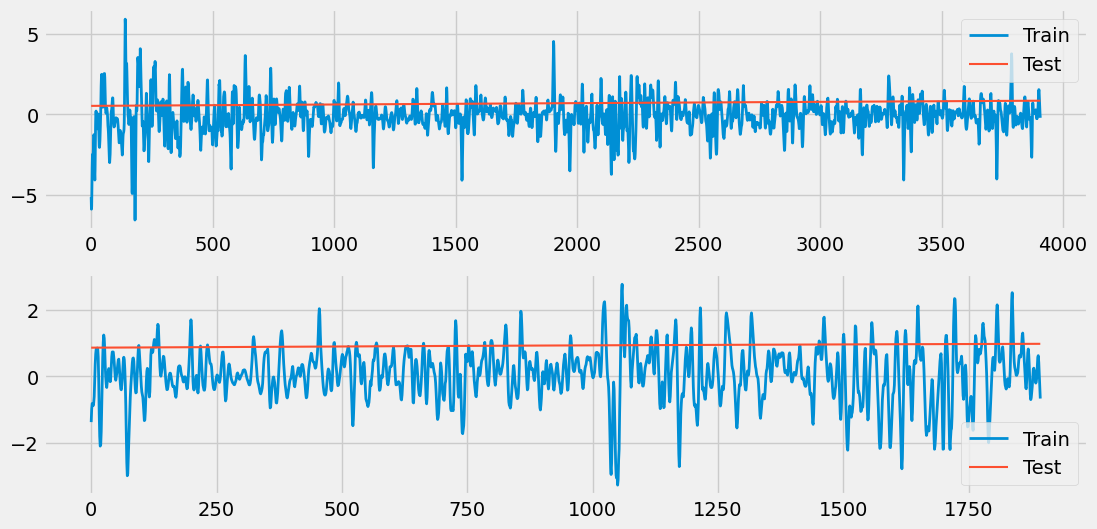

In [39]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))

ax1.plot(inv_train['MPN5P'].values, linewidth=2, label='Train')
ax1.plot(inv_train['Fitted MPN5P'].values, linewidth=1.5, label='Test')
ax1.legend()

ax2.plot(inv_test['MPN5P'].values, linewidth=2, label='Train')
ax2.plot(inv_test['Preds MPN5P'].values, linewidth=1.5, label='Test')
ax2.legend()

#### Target Plot Generator

In [40]:
def TPG_Trigger(scatter_x_value,
                scatter_y_value,
                scatter_x_label,
                scatter_y_label,
                ratio_x_value,
                ratio_y_value,
                ratio_x_label,
                ratio_y_label,
                comparison_x_value,
                comparison_y_value,
                comparison_x_label,
                comparison_y_label,
                dates,
                multiple_run_predictions_length,
                plot_name):
    headers={'Accept-Encoding': 'gzip, deflate, br','Content-Type': 'application/json','Accept': 'application/json','Connection': 'keep-alive','DNT': '1'}
    query = """
        query PlotMe(
            $scatter_x_value: [Float]!,
            $scatter_y_value: [Float]!,
            $scatter_x_label: String!,
            $scatter_y_label: String!,
            $ratio_x_value: [Float]!,
            $ratio_y_value: [Float]!,
            $ratio_x_label: String!,
            $ratio_y_label: String!,
            $comparison_x_value: [Float]!,
            $comparison_y_value: [Float]!,
            $comparison_x_label: String!,
            $comparison_y_label: String!,
            $dates: [String]!,
            $multiple_run_predictions_length: Int!,
            $plot_name: String!
        ) {
            plotme(
                scatter_x_value: $scatter_x_value,
                scatter_y_value: $scatter_y_value,
                scatter_x_label: $scatter_x_label,
                scatter_y_label: $scatter_y_label,
                ratio_x_value: $ratio_x_value,
                ratio_y_value: $ratio_y_value,
                ratio_x_label: $ratio_x_label,
                ratio_y_label: $ratio_y_label,
                comparison_x_value: $comparison_x_value,
                comparison_y_value: $comparison_y_value,
                comparison_x_label: $comparison_x_label,
                comparison_y_label: $comparison_y_label,
                dates: $dates,
                multiple_run_predictions_length: $multiple_run_predictions_length,
                plot_name: $plot_name
            ) {
                success
                errors
                    plots {
      plot_num
      plot_image
      plot_trend_slope
      plot_trend_intercept
      plot_trend_correlation
      plot_trend_standard_deviation
      plot_trend_dispersion
    }
            }
        }
    """

    variables = {
        "scatter_x_value": scatter_x_value,
        "scatter_y_value": scatter_y_value,
        "scatter_x_label": scatter_x_label,
        "scatter_y_label": scatter_y_label,
        "ratio_x_value": ratio_x_value,
        "ratio_y_value": ratio_y_value,
        "ratio_x_label": ratio_x_label,
        "ratio_y_label": ratio_y_label,
        "comparison_x_value": comparison_x_value,
        "comparison_y_value": comparison_y_value,
        "comparison_x_label": comparison_x_label,
        "comparison_y_label": comparison_y_label,
        "dates": dates,
        "multiple_run_predictions_length": multiple_run_predictions_length,
        "plot_name" : plot_name
    }
    data = {
        'query': query,
        'variables' : variables
    }

    response = requests.post('http://3.64.122.73:5002/graphql',headers=headers,json=data)
    print(response.text)
    return response.json()

In [43]:
y_actual = inv_test['MPN5P'].tolist()
y_pred = inv_test['Preds MPN5P'].tolist()

response = TPG_Trigger(
    scatter_x_value=y_actual,
    scatter_y_value=y_pred,
    scatter_x_label='X',
    scatter_y_label='Y',
    ratio_x_value=y_actual,
    ratio_y_value=y_pred,
    ratio_x_label='X',
    ratio_y_label='Y',
    comparison_x_value=y_actual,
    comparison_y_value=y_pred,
    comparison_x_label='X',
    comparison_y_label='Y',
    dates=dates,
    multiple_run_predictions_length = len(y_pred),
    plot_name='LTM_pretreated_features'
)

print(response)

{
  "data": {
    "plotme": {
      "errors": null,
      "plots": [
        {
          "plot_image": "iVBORw0KGgoAAAANSUhEUgAAA+gAAAPoCAYAAABNo9TkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdeXhU5dk/8O+ZJJNJMglkASFBi0ZUWgFRW15S80ItrS0UBEGlSlkUEBAQNAoB0bgB+gZFUUGLBRQt4gJCtdViG14oLq1V8f1hFRFbgSgGAslkm2Tm/P5IZpiZnOU5yywh3891eV0mc+Y5zzkzE+Z+lvuWZFmWQURERERERERx5Yh3B4iIiIiIiIiIAToRERERERFRQmCATkRERERERJQAGKATERERERERJQAG6EREREREREQJgAE6ERERERERUQJggE5ERERERESUABigExERERERESUABuhERERERERECYABOhEREREREVECYIBORERERERElAAYoBMRERERERElAAboRERERERERAmAAToRERERERFRAmCATkRERERERJQAGKATERERERERJQAG6EREREREREQJgAE6ERERERERUQJggE5ERERERESUABigExERERERESUABuhERERERERECYABOhEREREREVECYIBORERERERElAAYoBMRERERERElAAboRERERERERAmAAToRERERERFRAmCATkRERERERJQAGKATERERERERJQAG6EREREREREQJgAE6ERERERERUQJggE5ERERERESUABigExERERERESUABuhERERERERECYABOhEREREREVECYIBORERERERElAAYoBMRERERERElAAboRERERERERAmAAToRERERERFRAmCA